# STAREPandas Multiprocessing

In [1]:
import dask
import numpy
import starepandas
import geopandas
import pystare
import pandas
import matplotlib.pyplot as plt
import datetime
import time

In [2]:
us = geopandas.read_file('../tests/data/tl_2017_us_state.gpkg')
us = us.to_crs('EPSG:4326')
len(us)

56

In [3]:
us.head()
us = us[0:6]

## Parallel SID lookup

### Manual / low level

In [15]:
def sids_from_geoseries(series, resolution, convex=False, force_ccw=True, n_workers=1):
    sids = []
    for geom in series:
        sids_row = starepandas.sids_from_shapely(geom=geom, resolution=resolution, convex=convex, force_ccw=force_ccw)
        sids.append(sids_row)
    #sids = numpy.array(sids, dtype='int64')  # Has to be object to suppress VisibleDeprecationWarning
    return sids

In [16]:
n_workers = 2

ddf = dask.dataframe.from_pandas(us.geometry, npartitions=n_workers)
meta = {'sids': 'uint64'}

res = ddf.map_partitions(lambda df: numpy.array(sids_from_geoseries(df, resolution=7, convex=False, force_ccw=False, n_workers=1), dtype='object'), 
                         meta=meta)

sids = res.compute(scheduler='processes')
sids.dtype

dtype('O')

### High level

In [5]:
stare = starepandas.sids_from_geoseries(us.geometry, 
                                        resolution=9, 
                                        convex=False, 
                                        force_ccw=True, 
                                        n_workers=2)

# Parallel Trixel lookup

## Manual / low level

In [6]:
n_cores = 4

us['stare'] = stare
ddf = dask.dataframe.from_pandas(us['stare'], npartitions=n_cores)
meta = {'trixels': 'object'}

res = ddf.map_partitions(lambda df: numpy.array(starepandas.trixels_from_stareseries(df)), meta=meta)
trixels = res.compute(scheduler='processes')

## High level

In [7]:
stare = pandas.Series(stare)
trixels = starepandas.trixels_from_stareseries(stare, n_workers=55)

# Parallel instantiation

In [11]:
us = starepandas.STAREDataFrame(us, 
                                add_sids=True, 
                                resolution=7, 
                                add_trixels=True, 
                                n_workers=4)

<AxesSubplot:>

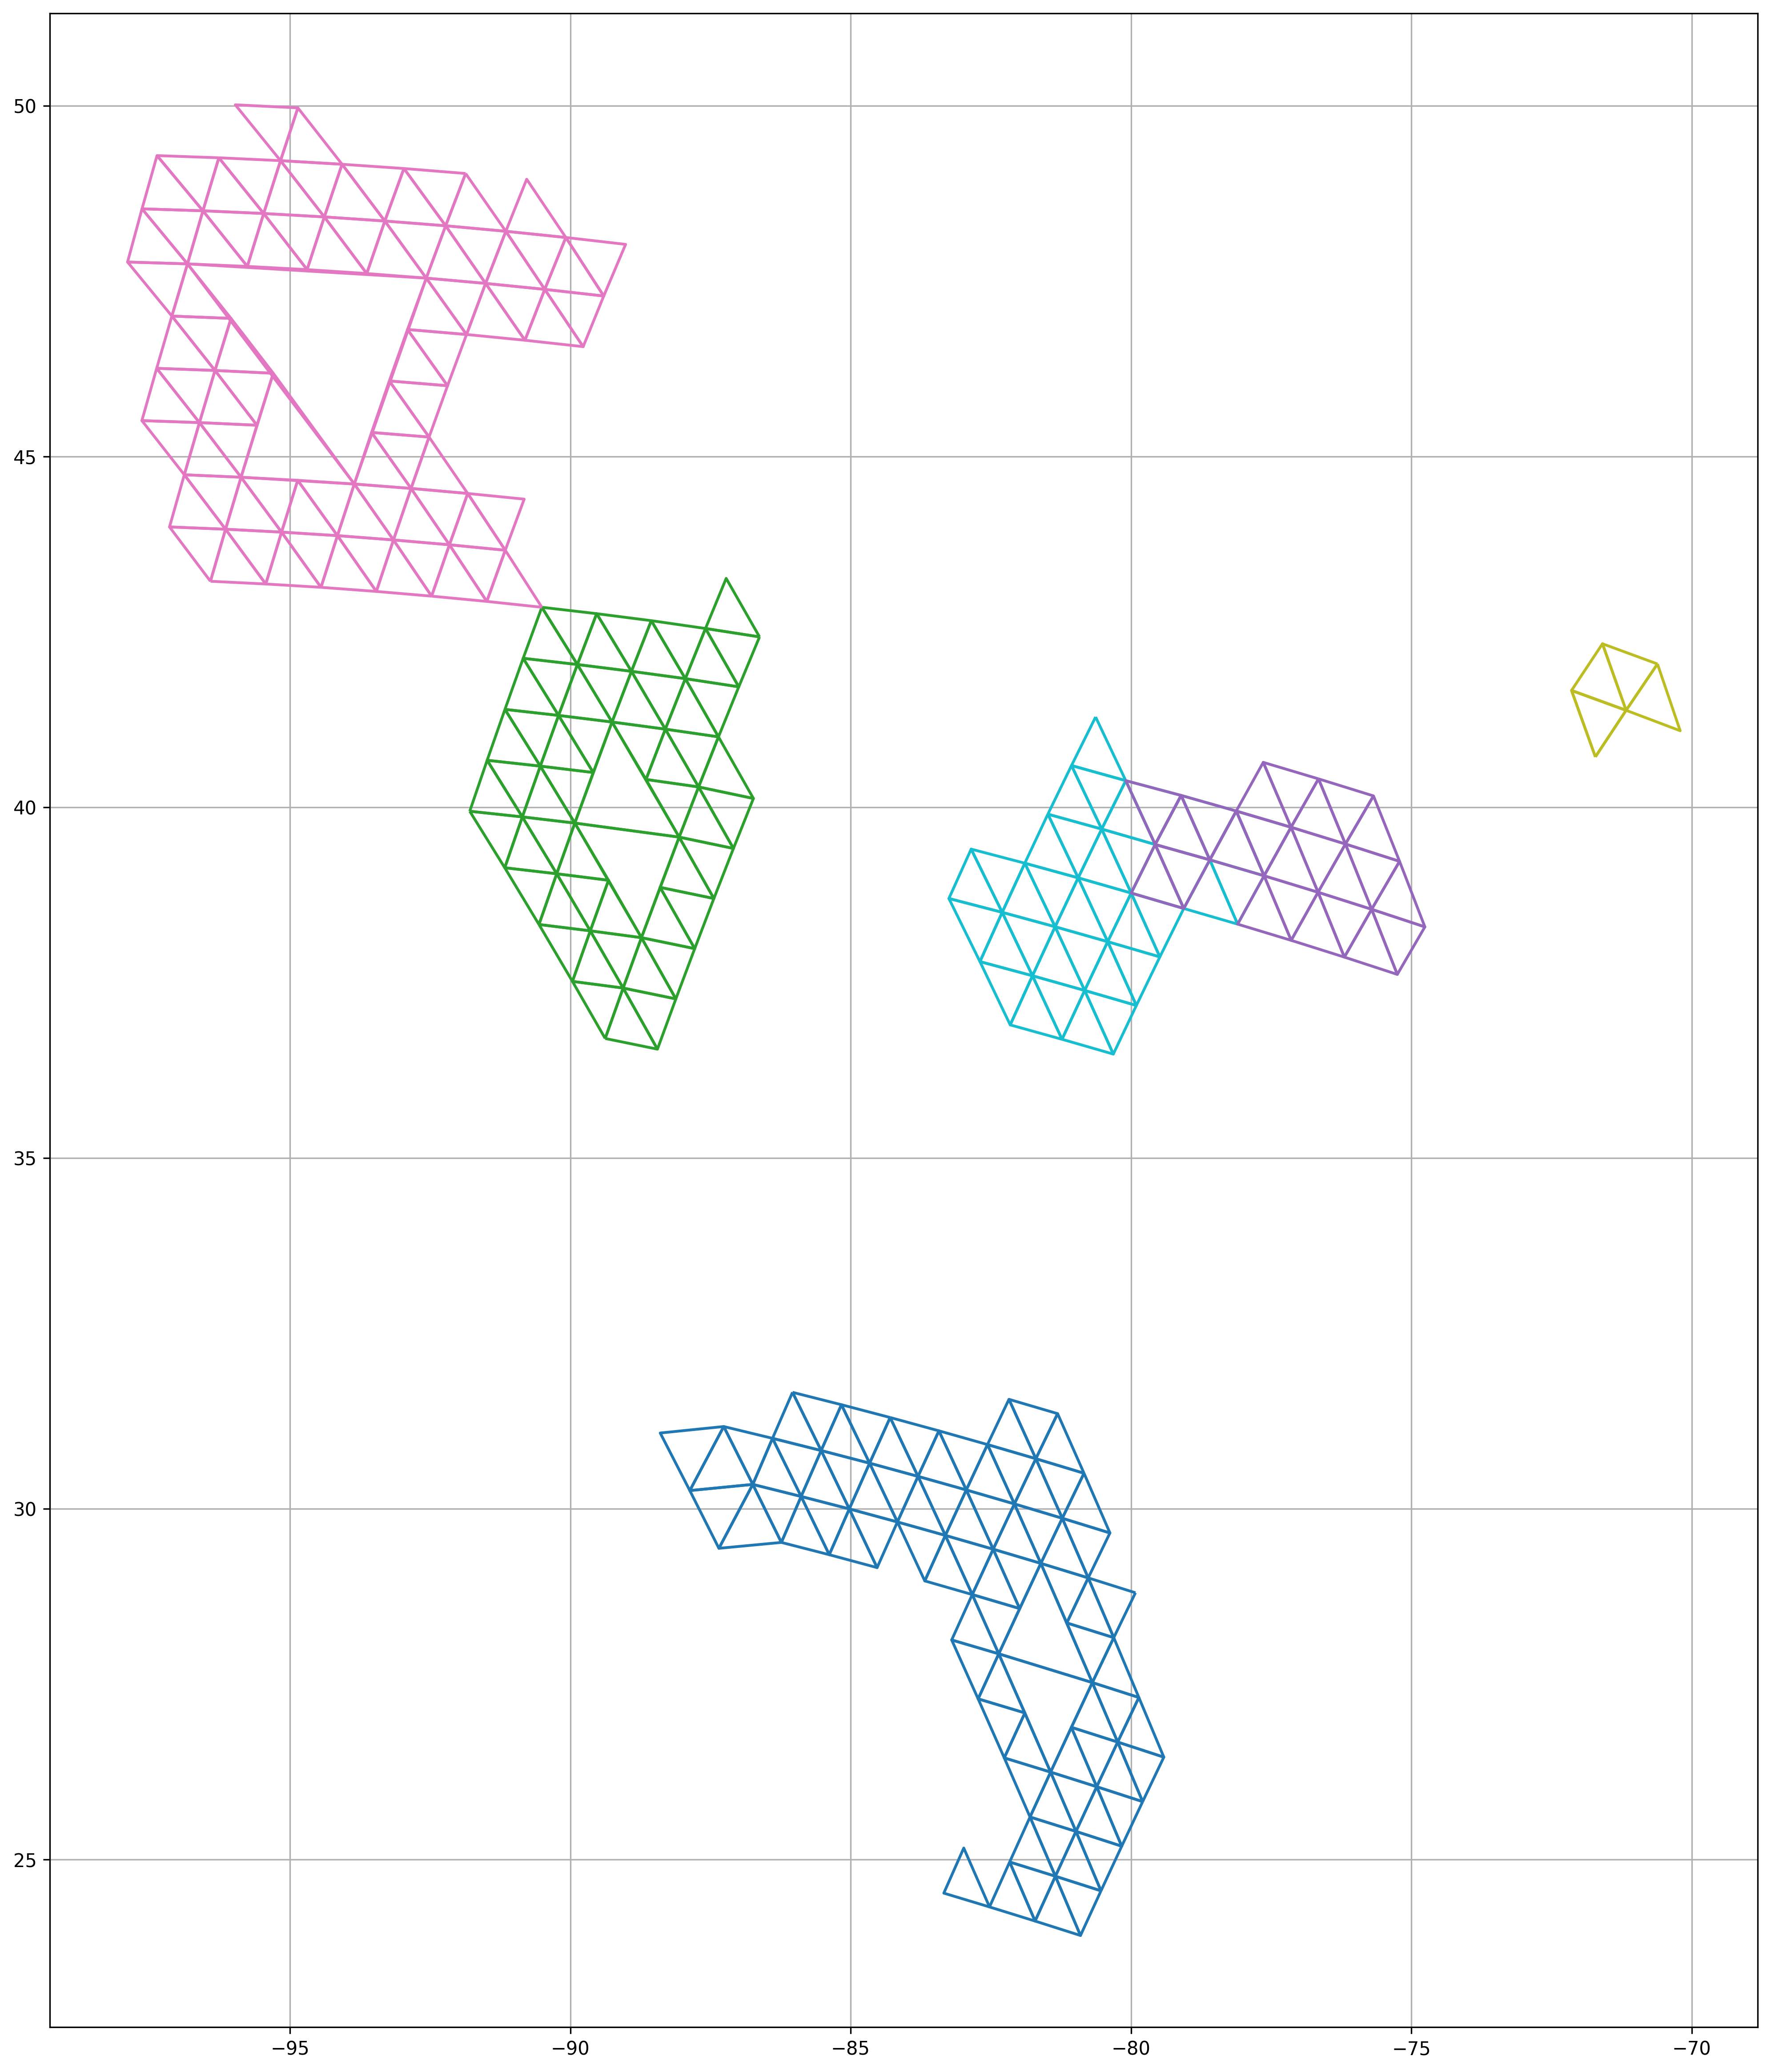

In [12]:
fig, ax = plt.subplots(figsize=(20,20), dpi=300)
ax.grid(True)

us.plot(ax=ax, trixels=True, column='NAME')

# Visualization

In [14]:
us

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,stare,sids,trixels
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62265662566,489840834,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...","[3141260740090920967, 3141331108835098631, 314...","[3137320090416971783, 3137355274789060615, 313...",(POLYGON ((-79.56820093460999 39.4697968050695...
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138911437206,31398800291,+28.4574302,-082.4091478,"MULTIPOLYGON (((-82.98748 24.62538, -82.98748 ...","[3119131969070301193, 3119134168093556745, 311...","[3119129770047045639, 3119446429395845126, 312...",(POLYGON ((-82.52250050441245 24.3262439528985...
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143784114293,6211277447,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643...","[3072299370796810246, 3072440108285165574, 307...","[3072299370796810246, 3072440108285165574, 307...",(POLYGON ((-88.73033291454283 38.1416177316210...
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206229176104,18944967530,+46.3158148,-094.1996628,"POLYGON ((-96.78438 46.63050, -96.78434 46.630...","[3077084445400891397, 3077647395354312710, 307...","[3077084445400891397, 3077647395354312710, 307...",(POLYGON ((-92.56837169290753 47.5424186474628...
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220...","[3168423075343499271, 3168528628459765767, 316...","[3137320090416971783, 3164341688181194759, 316...",(POLYGON ((-79.56820093460999 39.4697968050695...
5,1,1,44,01219835,44,RI,Rhode Island,00,G4000,A,2677997539,1323452846,+41.5974187,-071.5272723,"MULTIPOLYGON (((-71.67881 41.15891, -71.67626 ...","[3163710568506851337, 3163719364599873545, 316...","[3163708369483595783, 3163391710134796295, 316...",(POLYGON ((-71.71677712339738 40.7185745368057...


,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,stare,sids,trixels
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220...","[3168423075343499271, 3168528628459765767, 316...","[3137320090416971783, 3164341688181194759, 316...",(POLYGON ((-79.56820093460999 39.4697968050695...


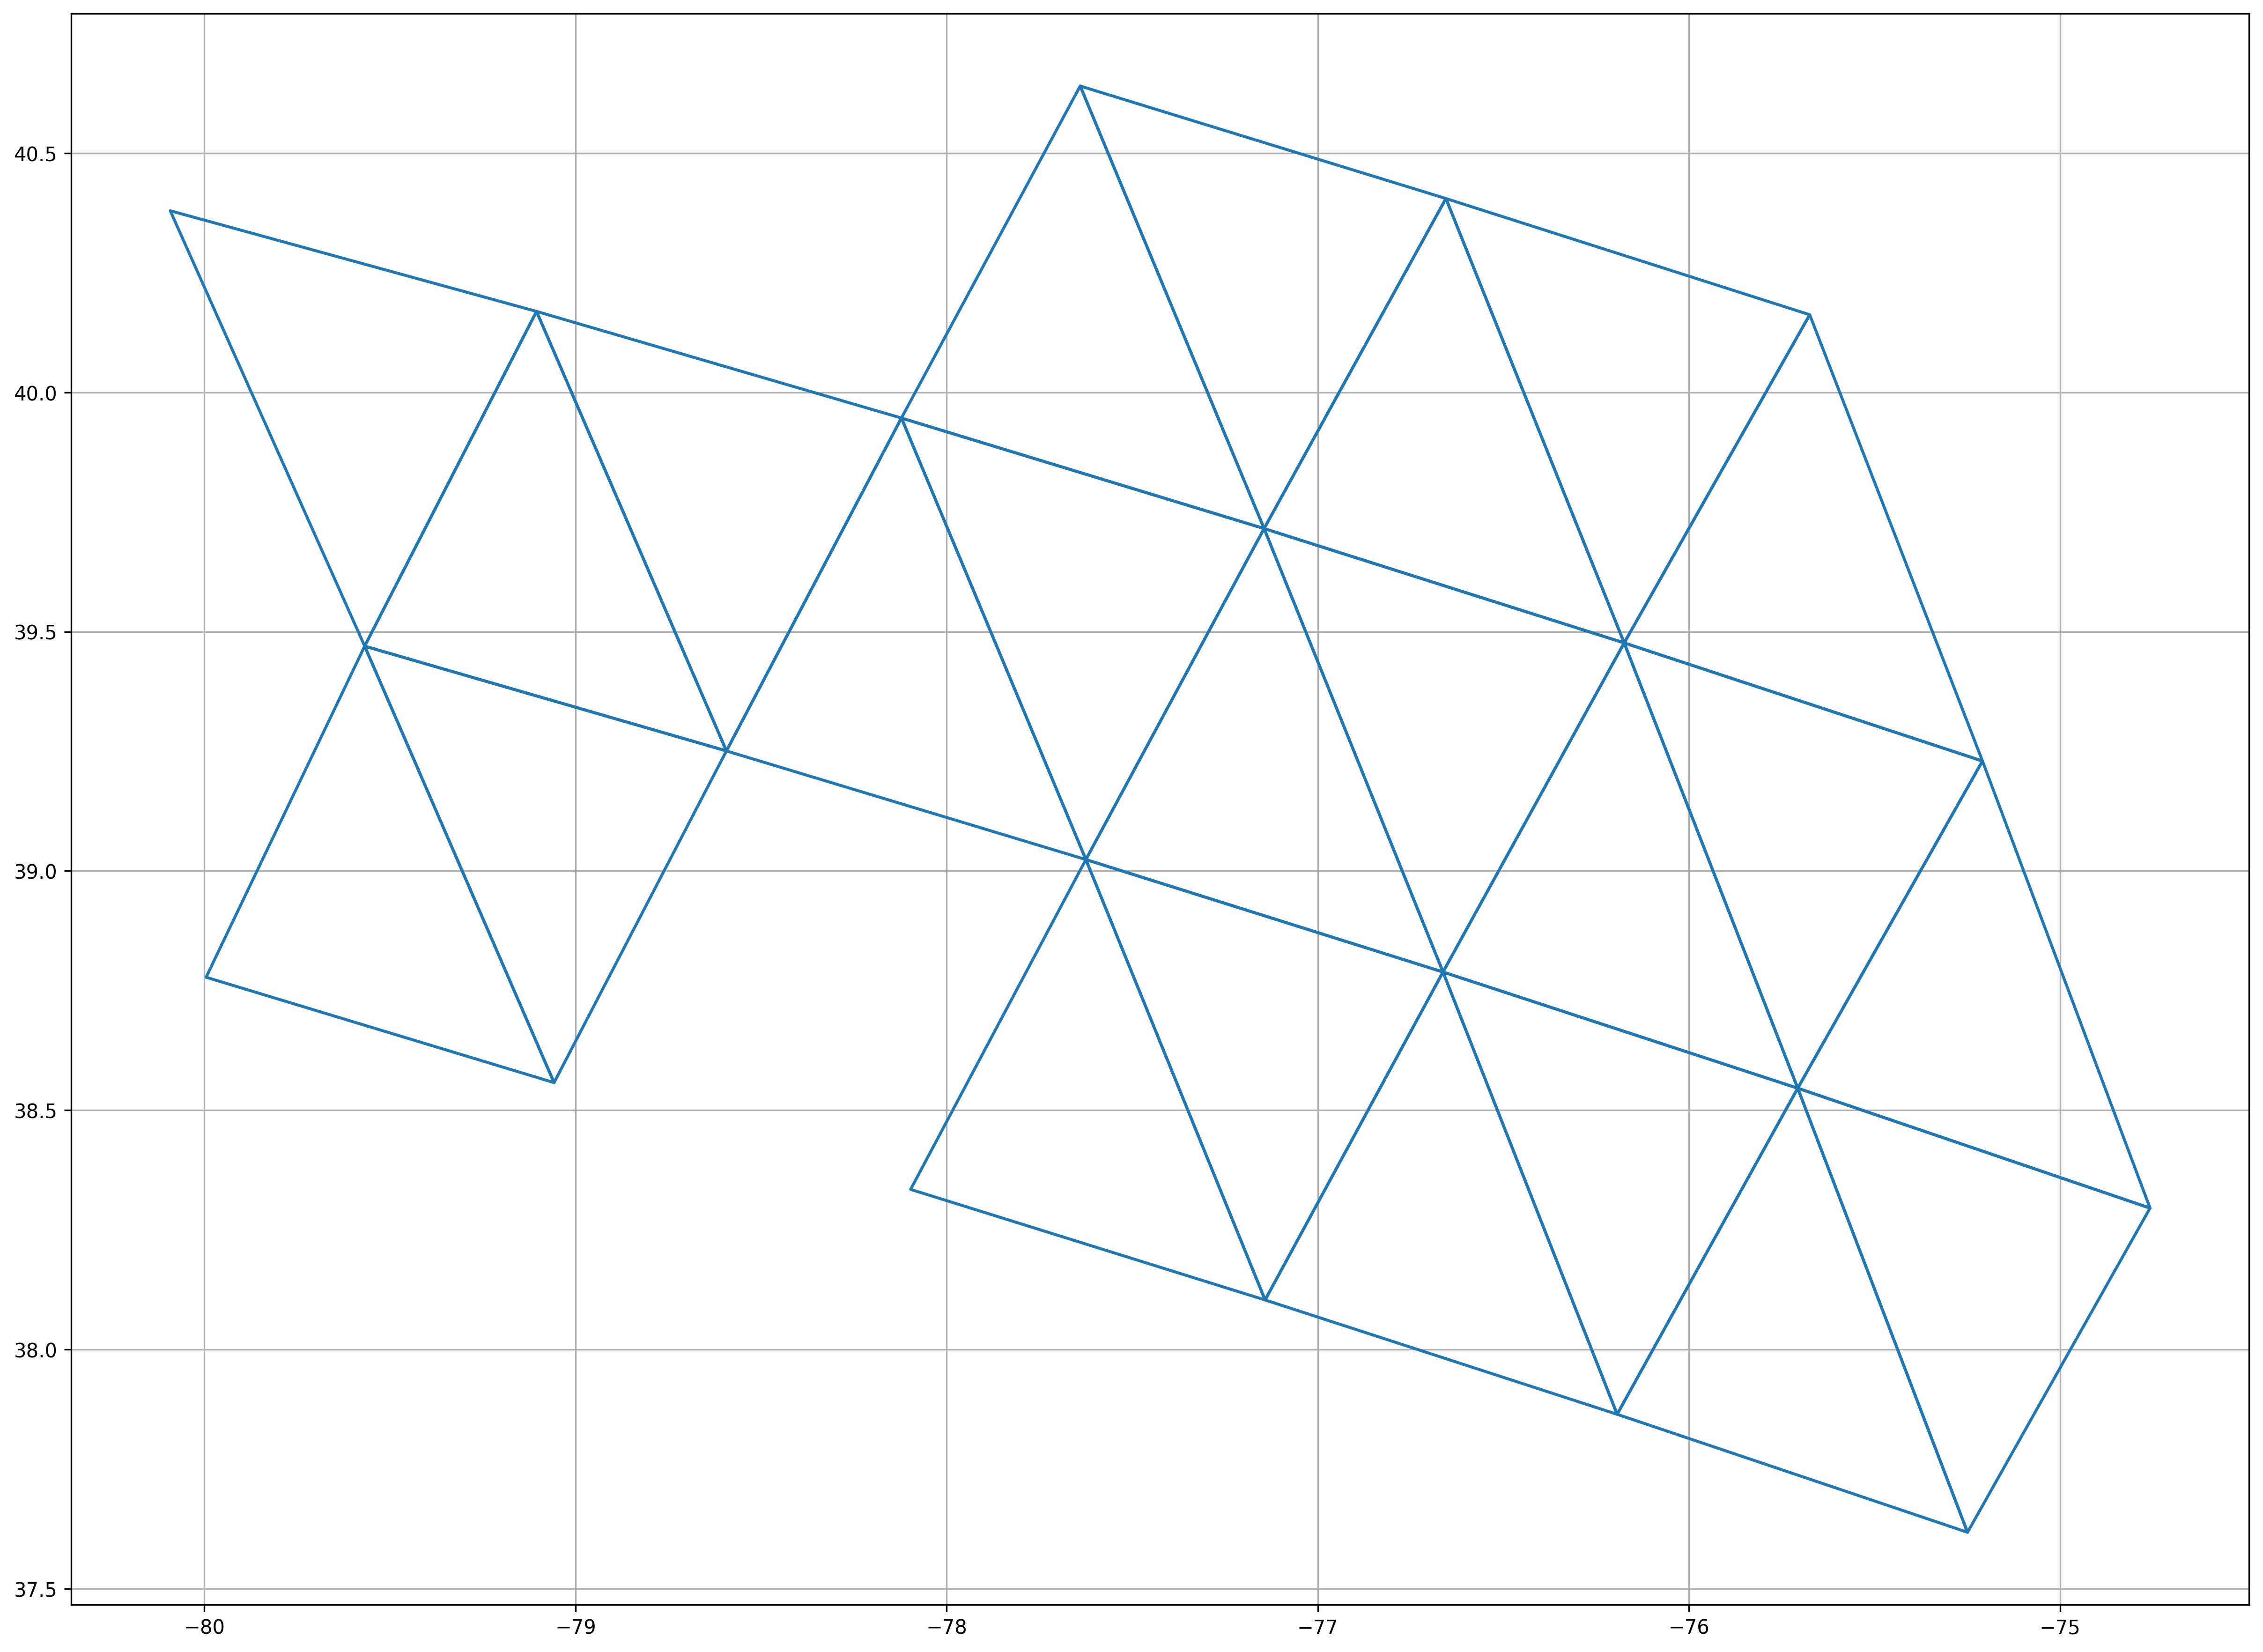

In [15]:
fig, ax = plt.subplots(figsize=(20,20), dpi=300)
ax.grid(True)

hawaii = us[us['NAME']=='Maryland']
hawaii.plot(ax=ax, trixels=True)
hawaii

# Parallel dissolve

In [16]:
us_regions = us.stare_dissolve(by='REGION', aggfunc='sum', n_workers=4, geom=False)

In [17]:
trixels = us_regions.make_trixels(n_workers=4)
us_regions.set_trixels(trixels, inplace=True)

<AxesSubplot:>

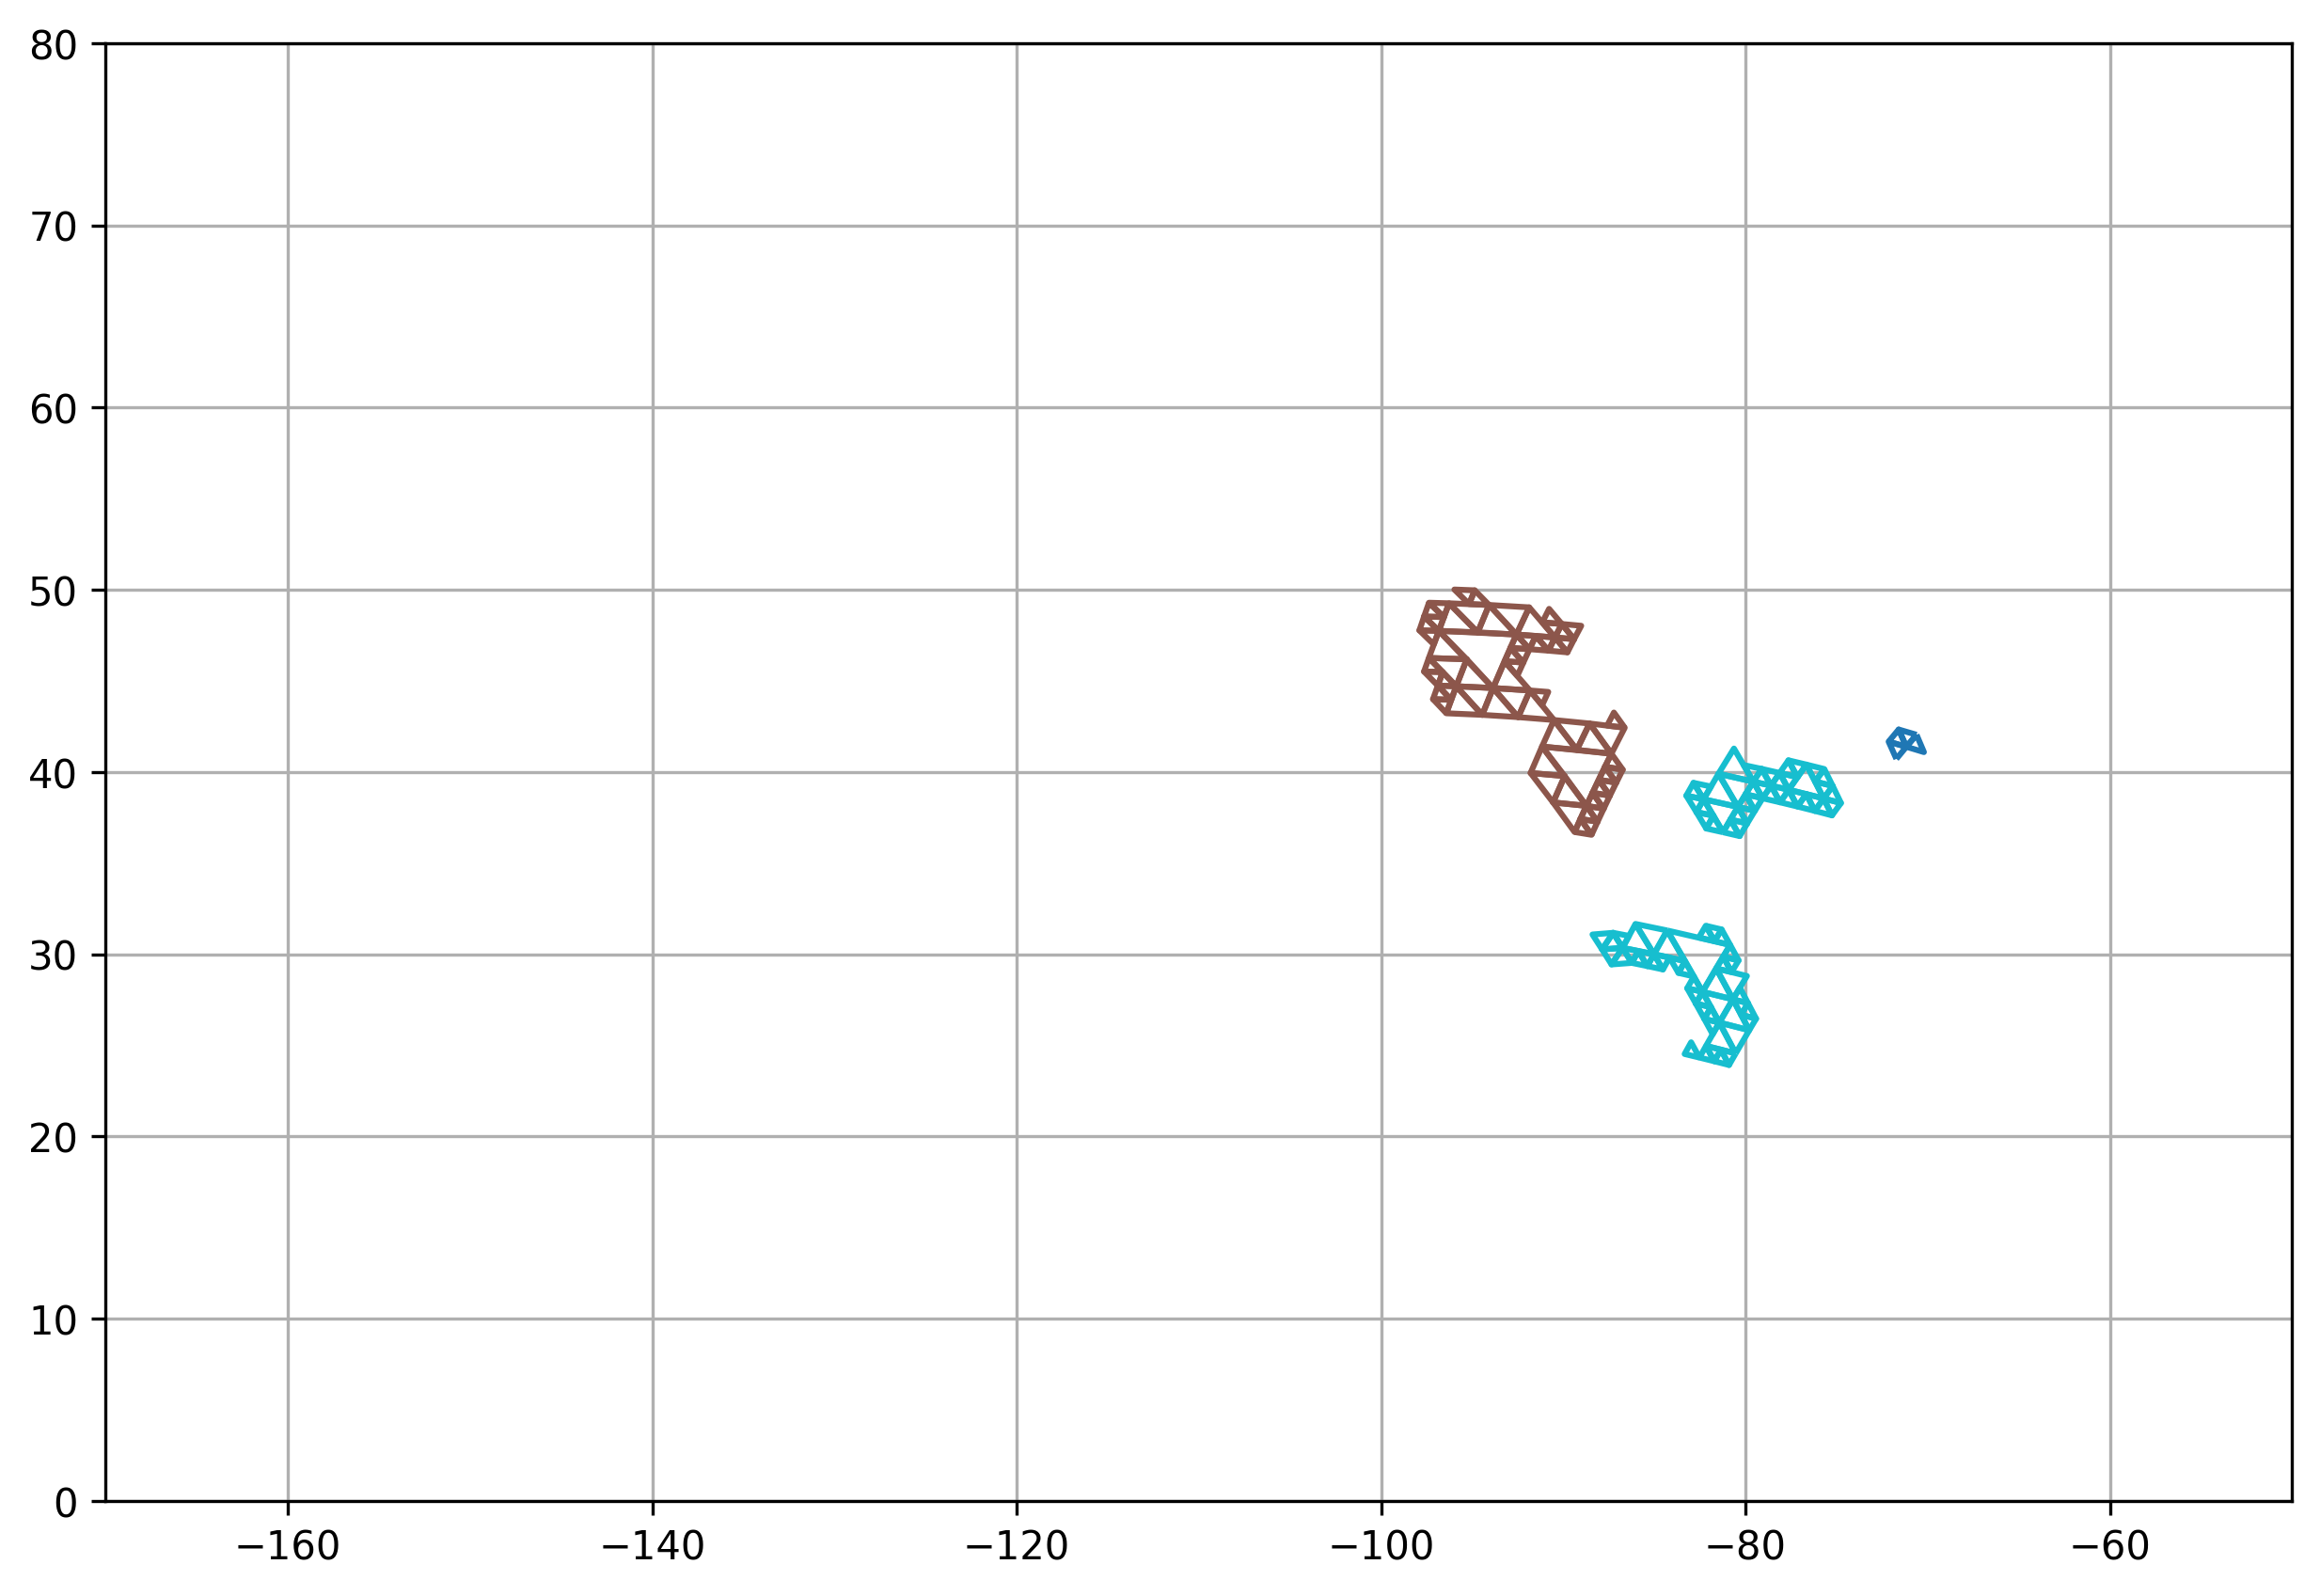

In [18]:
fig, ax = plt.subplots(figsize=(10,10), dpi=300)
ax.grid(True)

ax.set_xlim(-170, -50)
ax.set_ylim(0, 80)

us_regions.reset_index().plot(ax=ax, trixels=True, column='REGION')

# Parallel Intersects

## Cover

In [21]:
us = starepandas.STAREDataFrame(us, add_sids=True, 
                                resolution=8, add_trixels=True, n_workers=4)

In [23]:
filepath = '../tests/data/granules/VNP03DNB.A2020219.0742.001.2020219124651.nc'
vnp03 = starepandas.io.granules.VNP03DNB(filepath)
vnp03.read_sidecar_cover()
vnp03_cover = vnp03.stare_cover
vnp03_cover_df = starepandas.STAREDataFrame({'stare': vnp03.stare_cover}, sids='stare', add_trixels=True)

<AxesSubplot:>

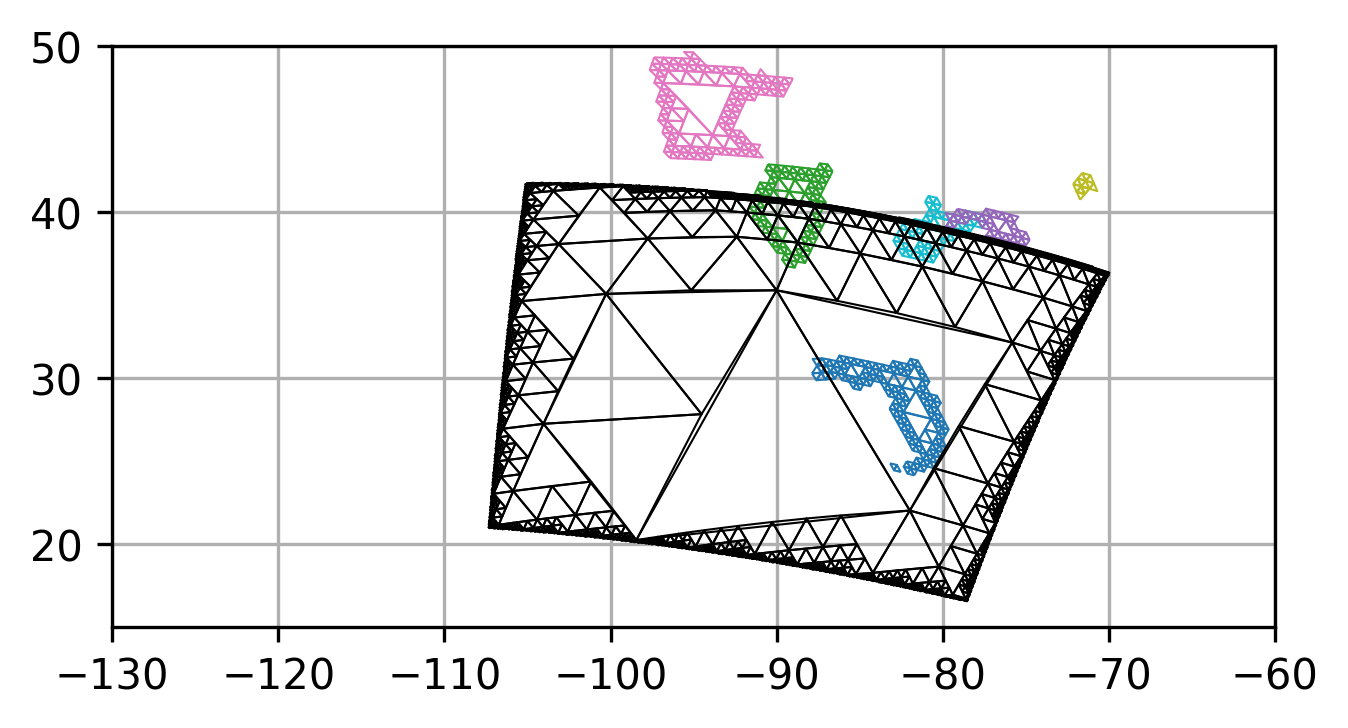

In [24]:
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
ax.grid(True)

ax.set_xlim(-130, -60)
ax.set_ylim(15, 50)

us.plot(ax=ax, column='NAME', trixels=True, linewidth=0.5)
vnp03_cover_df.plot(ax=ax, trixels=True, color='k', linewidth=0.5)

In [25]:
def series_intersects(other, series, method=1, n_workers=1):
    """ 
    Returns a bool series of length len(series).
    True for every row in which row intersects other.    
    """
    
    if n_workers > len(series):
        # Cannot have more partitions than rows        
        n_workers = len(series) 
        
    if n_workers == 1:
        if series.dtype == numpy.int64:     
            # We have a series of sids; don't need to iterate. Can send the whole array to pystare/
            intersects = pystare.intersects(other, series, method)
        else:
            intersects = []   
            for sids in series:        
                if len(sids) < len(other):
                    # If we do method 1, larger item first is faster
                    intersects.append(pystare.intersects(other, sids, method).any())
                else:
                    intersects.append(pystare.intersects(sids, other, method).any())
            intersects = numpy.array(intersects)
    else:
        ddf = dask.dataframe.from_pandas(series, npartitions=n_workers)
        meta = {'intersects': 'bool'}
        res = ddf.map_partitions(lambda df: series_intersects(other, df, method, 1), meta=meta)
        intersects = res.compute(scheduler='processes')    
    return intersects

In [26]:
a = numpy.array(vnp03_cover)

In [27]:
start = datetime.datetime.now()
intersects = series_intersects(a, us['stare'] , 1, 1)
print(datetime.datetime.now() - start)

0:00:00.007041


In [28]:
start = datetime.datetime.now()
intersects = series_intersects(a, us['stare'], 1, 5)
print(datetime.datetime.now() - start)

0:00:00.772815


In [29]:
intersects

array([ True,  True,  True, False,  True, False])

In [30]:
print(list(us[intersects]['NAME']))

['West Virginia', 'Florida', 'Illinois', 'Maryland']


## iFOVs

In [31]:
filepath = '../tests/data/granules/VNP03DNB.A2020219.0742.001.2020219124651.nc'
vnp03 = starepandas.read_granule(filepath, sidecar=True)

In [32]:
state_sids = us[us['NAME']=='Florida']['stare'].iloc[0]

In [34]:
start = datetime.datetime.now()
intersects = series_intersects(state_sids, vnp03['sids'])
print(datetime.datetime.now() - start)

0:00:32.821202


In [35]:
start = datetime.datetime.now()
intersects = series_intersects(state_sids, vnp03['stare'], 1, 60)
print(datetime.datetime.now() - start)

KeyError: 'stare'

In [ ]:
intersects.sum()/vnp03.index.size

In [ ]:
vnp03[intersects]

## High level

In [ ]:
intersects = vnp03.stare_intersects(other=state_sids, method=1, n_workers=20)